In [143]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, normalize, MaxAbsScaler,MinMaxScaler, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split,cross_val_score,learning_curve, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
import matplotlib.pyplot as plt
import seaborn as sns

### 第一步：导入数据，数据总揽

In [144]:
"""
读入数据
"""
train_data = pd.read_csv("titanic_dataset/train.csv")
test_data = pd.read_csv('titanic_dataset/test.csv')
data = train_data.append(test_data,ignore_index=True)

In [145]:
# 总揽数据信息
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [146]:
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


### 第二步：数据预处理

In [147]:
data.Embarked.value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [130]:
# 上船地点的缺失值按大概率填充
data.Embarked[data.Embarked.isnull()] = 'S'

In [131]:
# 船票价格只有一个缺失值，用平均值填充，数据偏移较正，使其符合模型假设
data.Fare[data.Fare.isnull()] = data.Fare.mean()

In [149]:
# 无关特征删除，需要做特征选择
# Cabin特征因为缺失比例大于75，所以选择删除

delete_features = ['Name','Cabin','Ticket','PassengerId']
data = data.drop(delete_features,axis=1)

In [150]:
# 性别、上船地点、舱位三个离散型特征采用独热编码
features = ['Embarked','Sex','Pclass']
enc = OneHotEncoder(sparse= False)
ans = enc.fit_transform(data[features],)
new_features = ['Embarked_S','Embarked_Q','Embarked_C','Sex_female','Sex_male','Pclass_1','Pclass_2','Pclass_3']
one_hot = pd.DataFrame(data=ans,columns=new_features)

ValueError: Input contains NaN

In [134]:
data = pd.concat([data,one_hot],axis=1).drop(['Pclass','Sex','Embarked'],axis=1)

In [135]:
# 分离训练集标签

y_train = data.Survived.loc[:890]
data = data.drop('Survived',axis=1)

In [136]:
# 随机森林回归填补年龄缺失值

Age_train = data[data.Age.notnull()]
X_Age_test = data[data.Age.isnull()]
Age_y_train = Age_train.Age
Age_X_train = Age_train.drop('Age',axis=1)

RFR = RandomForestRegressor(n_estimators=200,random_state=1)
RFR.fit(Age_X_train,Age_y_train)
age_for_null = RFR.predict(X_Age_test.drop('Age',axis=1))

In [137]:
data.Age[data.Age.isnull()] = age_for_null

In [138]:
X_train = data.loc[:890]
X_test = data.loc[891:]

### 第三步：模型评估选择和参数调节

In [139]:
# 样本参数设置
train_size_list = [int(x) for x in range(50,train_data.shape[0]-200,50)]


In [55]:
# 网格搜索调节超参
rfc = RandomForestClassifier()
parameters_range = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
feature_range = [1,2,3,4,5,6,7,8,9,10]
parameters = {'max_depth':parameters_range,'n_estimators':parameters_range,'max_features':feature_range}
gs = GridSearchCV(estimator=rfc,cv=5,param_grid=parameters)
gs.fit(X_train,y_train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [56]:
gs.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features=6, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=17,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### 第四步：可视化模型性能

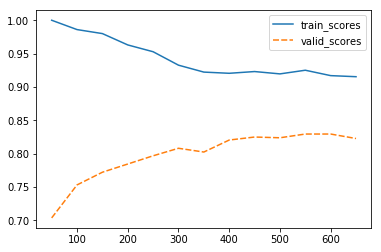

In [140]:
# randomforest
# 绘制学习曲线看模型是否过拟合和欠拟合

rfc = RandomForestClassifier(n_estimators=17,max_depth=8,max_features=6,random_state=1,criterion='gini',min_samples_split=2)
train_sizes, train_scores, valid_scores = learning_curve(rfc,X_train,y_train,train_sizes = train_size_list ,cv=5)
temp_data = pd.DataFrame({'train_scores':np.mean(train_scores,axis=1),'valid_scores':np.mean(valid_scores,axis=1)},index=train_size_list)
ax = sns.lineplot(hue='event',data=temp_data)

### 第五步：训练模型，输出预测结果

In [141]:
def final_file(model):
    model.fit(X_train,y_train)
    prediction = model.predict(X_test)
    file = pd.DataFrame({'Survived':prediction.astype(np.uint32)},index=test_data.PassengerId)
    file.to_csv('random_forest.csv')

In [142]:
final_file(rfc)